# Simple LSTM for track finding on 1D detector layers

In [1]:
# System imports
from __future__ import print_function

# External imports
import numpy as np
from keras import models
from keras import layers

# Local imports
from data import (generate_straight_track, generate_straight_tracks,
                  generate_uniform_noise, generate_track_bkg)
from drawing import draw_2d_event, draw_2d_input_and_pred

from matplotlib import pyplot as plt
%matplotlib notebook

Using Theano backend.
Using gpu device 7: GeForce GTX 1080 (CNMeM is disabled, cuDNN 5105)
/usr/local/lib/python2.7/dist-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


## Data generation

In [2]:
# Config parameters
det_width = 50
det_depth = 50
det_shape = (det_depth, det_width)
num_events = 100000

In [3]:
# Generate a sample of single-track events
tracks = generate_straight_tracks(num_events, det_shape)
train_input = tracks
train_target = tracks
print(train_input.shape)

(100000, 50, 50)


## Simple LSTM track fitting model

In [4]:
def build_model(num_hidden=10, length=det_depth, dim=det_width,
                loss='categorical_crossentropy',
                optimizer='Nadam', metrics=['accuracy']):
    inputs = layers.Input(shape=(length, dim))
    hidden = layers.LSTM(output_dim=num_hidden, return_sequences=True)(inputs)
    outputs = layers.TimeDistributed(layers.Dense(dim, activation='softmax'))(hidden)
    model = models.Model(input=inputs, output=outputs)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

In [5]:
# Instantiate the model
model1 = build_model()
# Train on the entire training set
model1.fit(train_input, train_target, batch_size=500, nb_epoch=10)
# Get all of the training data predictions
train_pred = model1.predict(train_input)

Epoch 1/10
100000/100000 [==============================] - 19s - loss: 3.1218 - acc: 0.2837    
Epoch 2/10
100000/100000 [==============================] - 19s - loss: 1.3973 - acc: 0.8255    
Epoch 3/10
100000/100000 [==============================] - 19s - loss: 0.5010 - acc: 0.9798    
Epoch 4/10
100000/100000 [==============================] - 19s - loss: 0.1994 - acc: 0.9946    
Epoch 5/10
100000/100000 [==============================] - 19s - loss: 0.1021 - acc: 0.9992    
Epoch 6/10
100000/100000 [==============================] - 20s - loss: 0.0610 - acc: 0.9998    
Epoch 7/10
100000/100000 [==============================] - 19s - loss: 0.0405 - acc: 1.0000    
Epoch 8/10
100000/100000 [==============================] - 20s - loss: 0.0289 - acc: 1.0000    
Epoch 9/10
100000/100000 [==============================] - 19s - loss: 0.0217 - acc: 1.0000    
Epoch 10/10
100000/100000 [==============================] - 19s - loss: 0.0169 - acc: 1.0000    


<IPython.core.display.Javascript object>


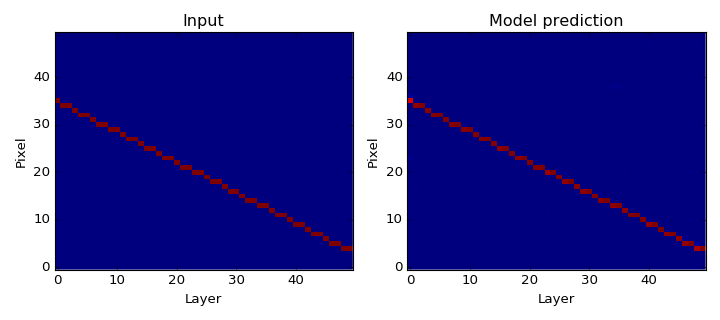

In [12]:
# Display one sample from the training set
display_idx = 10
draw_2d_input_and_pred(train_input[display_idx], train_pred[display_idx])

## Two-track events

<IPython.core.display.Javascript object>


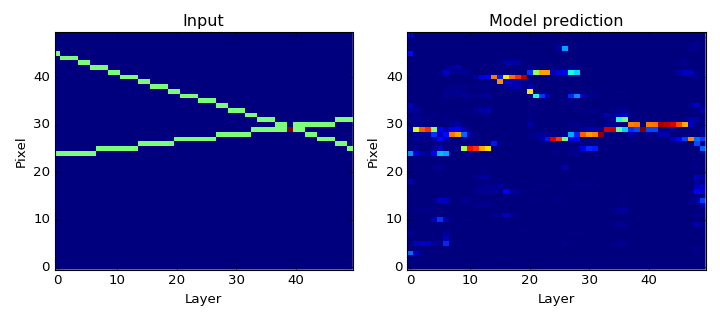

In [7]:
# Try adding two tracks into one image and see how the model does without any retraining
t1 = generate_straight_track(det_shape)
t2 = generate_straight_track(det_shape)
t3 = t1 + t2
t3_input = np.expand_dims(t3, 0)
t3_pred = model1.predict(t3_input)

# Plot the event and the corresponding prediction
draw_2d_input_and_pred(t3, t3_pred[0])

In [8]:
# Now lets generate events with 2 tracks each and train on that
events2 = sum([generate_straight_tracks(50000, det_shape) for i in range(2)])
train2_input = events2
train2_target = events2

In [9]:
# Create a new model
model2 = build_model(num_hidden=20)
model2.fit(train2_input, train2_target, batch_size=500, nb_epoch=10)
train2_pred = model2.predict(train2_input)

Epoch 1/10
50000/50000 [==============================] - 11s - loss: 6.8707 - acc: 0.1740    
Epoch 2/10
50000/50000 [==============================] - 12s - loss: 4.3503 - acc: 0.4668    
Epoch 3/10
50000/50000 [==============================] - 12s - loss: 2.8005 - acc: 0.5145    
Epoch 4/10
50000/50000 [==============================] - 12s - loss: 2.1500 - acc: 0.5148    
Epoch 5/10
50000/50000 [==============================] - 12s - loss: 1.8610 - acc: 0.5138    
Epoch 6/10
50000/50000 [==============================] - 12s - loss: 1.7115 - acc: 0.5155    
Epoch 7/10
50000/50000 [==============================] - 12s - loss: 1.6237 - acc: 0.5169    
Epoch 8/10
50000/50000 [==============================] - 12s - loss: 1.5673 - acc: 0.5167    
Epoch 9/10
50000/50000 [==============================] - 11s - loss: 1.5283 - acc: 0.5158    
Epoch 10/10
50000/50000 [==============================] - 12s - loss: 1.4997 - acc: 0.5154    


<IPython.core.display.Javascript object>


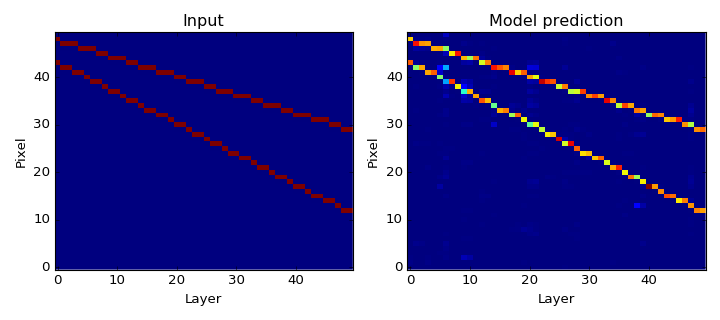

In [10]:
# Display one sample from the training set
display_idx = 666
draw_2d_input_and_pred(events2[display_idx], train2_pred[display_idx])

## Single tracks with uniform noise
In training, the inputs to the network are the events with the tracks and noise. However, in this case the target is the not same event, but rather the track by itself (still shifted by 1 index). Let's see if we can get this to work.

<IPython.core.display.Javascript object>


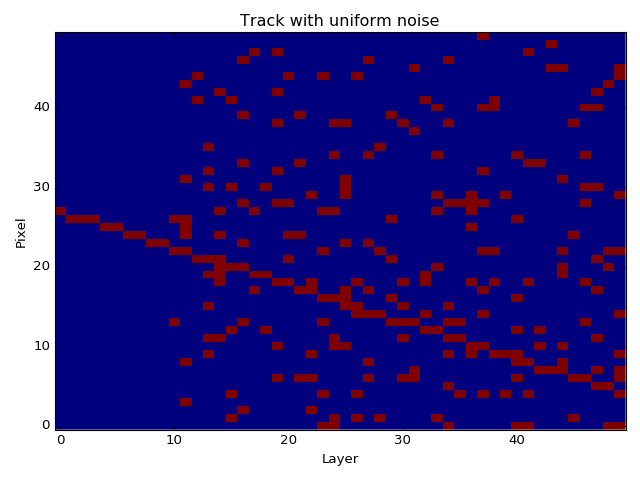

In [14]:
noise = generate_uniform_noise(len(tracks), det_shape, skip_layers=10)
events3 = tracks + noise
events3[events3 > 1] = 1

# Define the inputs and target
train3_input = events3
train3_target = tracks

# Let's take a quick look at one of these noise events
plt.figure()
draw_2d_event(events3[66], title='Track with uniform noise')

In [15]:
# Instantiate the model
model3 = build_model(num_hidden=50)
# Train the network
model3.fit(train3_input, train3_target, batch_size=500, nb_epoch=10)
# Get the final predictions from the entire training set
train3_pred = model3.predict(train3_input)

Epoch 1/10
100000/100000 [==============================] - 25s - loss: 2.1306 - acc: 0.5097    
Epoch 2/10
100000/100000 [==============================] - 25s - loss: 0.7052 - acc: 0.8538    
Epoch 3/10
100000/100000 [==============================] - 25s - loss: 0.3945 - acc: 0.9123    
Epoch 4/10
100000/100000 [==============================] - 25s - loss: 0.2558 - acc: 0.9363    
Epoch 5/10
100000/100000 [==============================] - 25s - loss: 0.1959 - acc: 0.9466    
Epoch 6/10
100000/100000 [==============================] - 25s - loss: 0.1731 - acc: 0.9506    
Epoch 7/10
100000/100000 [==============================] - 25s - loss: 0.1530 - acc: 0.9543    
Epoch 8/10
100000/100000 [==============================] - 23s - loss: 0.1250 - acc: 0.9596    
Epoch 9/10
100000/100000 [==============================] - 28s - loss: 0.1100 - acc: 0.9633    
Epoch 10/10
100000/100000 [==============================] - 28s - loss: 0.0994 - acc: 0.9659    


<IPython.core.display.Javascript object>


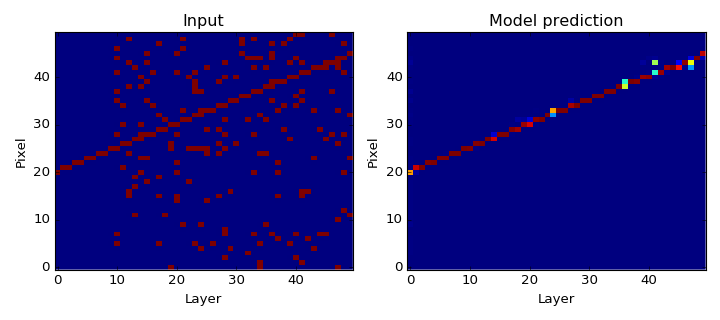

In [16]:
display_idx = 12050
draw_2d_input_and_pred(events3[display_idx], train3_pred[display_idx])

let's try to make it a little more difficult by decreasing the seed size and increasing the noise level

<IPython.core.display.Javascript object>


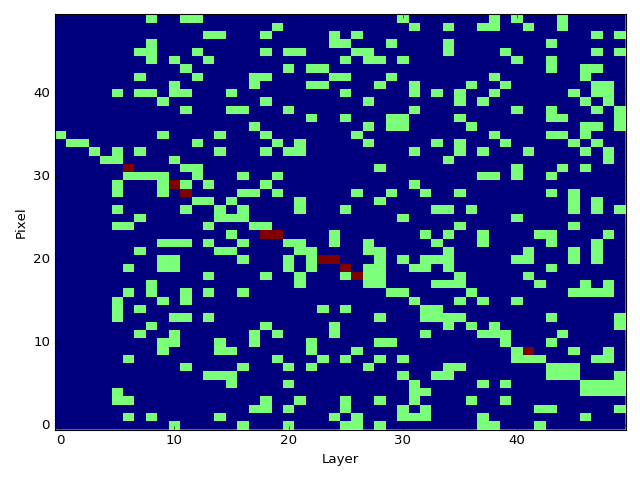

In [17]:
noise = generate_uniform_noise(len(tracks), det_shape, skip_layers=5, prob=0.2)
events4 = tracks + noise
train4_input = events4
train4_target = tracks
plt.figure()
draw_2d_event(events4[10])

In [18]:
model4 = build_model(num_hidden=50)
model4.fit(train4_input, train4_target, batch_size=500, nb_epoch=10)
train4_pred = model4.predict(train4_input)

Epoch 1/10
100000/100000 [==============================] - 28s - loss: 2.3796 - acc: 0.4214    
Epoch 2/10
100000/100000 [==============================] - 28s - loss: 1.1108 - acc: 0.7144    
Epoch 3/10
100000/100000 [==============================] - 27s - loss: 0.6915 - acc: 0.8098    
Epoch 4/10
100000/100000 [==============================] - 24s - loss: 0.5161 - acc: 0.8521    
Epoch 5/10
100000/100000 [==============================] - 25s - loss: 0.4176 - acc: 0.8762    
Epoch 6/10
100000/100000 [==============================] - 25s - loss: 0.3483 - acc: 0.8923    
Epoch 7/10
100000/100000 [==============================] - 25s - loss: 0.2977 - acc: 0.9050    
Epoch 8/10
100000/100000 [==============================] - 25s - loss: 0.2599 - acc: 0.9138    
Epoch 9/10
100000/100000 [==============================] - 25s - loss: 0.2890 - acc: 0.9100    
Epoch 10/10
100000/100000 [==============================] - 25s - loss: 0.2208 - acc: 0.9234    


<IPython.core.display.Javascript object>


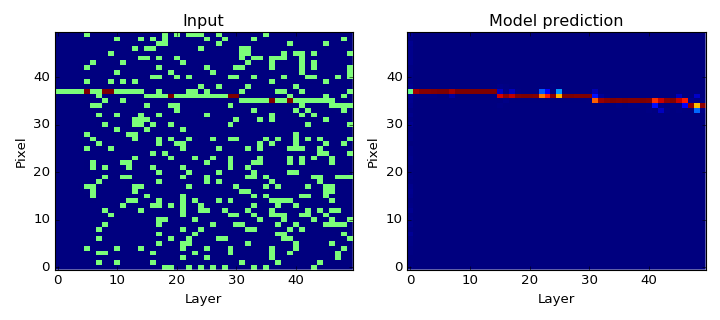

<IPython.core.display.Javascript object>


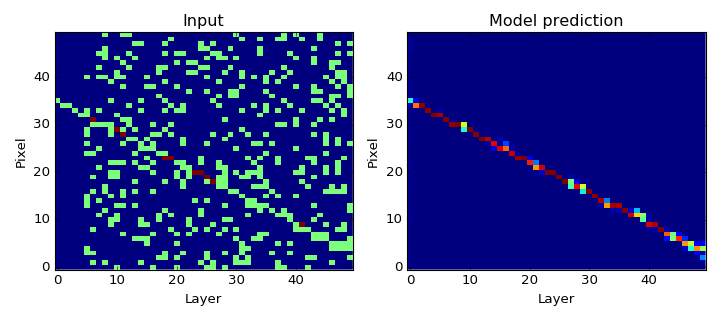

In [19]:
display_idx = 444
draw_2d_input_and_pred(events4[display_idx], train4_pred[display_idx])

display_idx = 10
draw_2d_input_and_pred(events4[display_idx], train4_pred[display_idx])

## Multi-track background

Now let's try the scenario where each event has background tracks in addition to the signal track.

In [20]:
# Generate the bkg data
bkgs = generate_track_bkg(tracks.shape[0], det_shape, tracks_per_event=5)
events5 = bkgs + tracks
events5[events5 > 1] = 1
train5_input = events5
train5_target = tracks

In [21]:
model5 = build_model(num_hidden=100)
%time model5.fit(train5_input, train5_target, batch_size=200, nb_epoch=10)
train5_pred = model5.predict(train5_input)

Epoch 1/10
100000/100000 [==============================] - 57s - loss: 1.8507 - acc: 0.4642    
Epoch 2/10
100000/100000 [==============================] - 57s - loss: 0.8546 - acc: 0.7041    
Epoch 3/10
100000/100000 [==============================] - 56s - loss: 0.6138 - acc: 0.7833    
Epoch 4/10
100000/100000 [==============================] - 48s - loss: 0.5076 - acc: 0.8191    
Epoch 5/10
100000/100000 [==============================] - 49s - loss: 0.4375 - acc: 0.8440    
Epoch 6/10
100000/100000 [==============================] - 49s - loss: 0.3922 - acc: 0.8596    
Epoch 7/10
100000/100000 [==============================] - 49s - loss: 0.3539 - acc: 0.8727    
Epoch 8/10
100000/100000 [==============================] - 50s - loss: 0.3334 - acc: 0.8808    
Epoch 9/10
100000/100000 [==============================] - 49s - loss: 0.3117 - acc: 0.8881    
Epoch 10/10
100000/100000 [==============================] - 49s - loss: 0.3007 - acc: 0.8930    
CPU times: user 5min 48s, sys

<IPython.core.display.Javascript object>


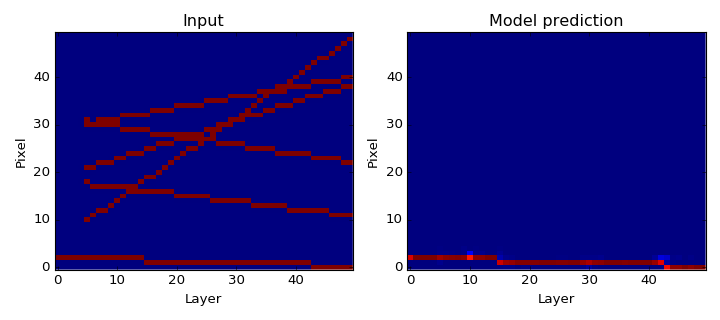

<IPython.core.display.Javascript object>


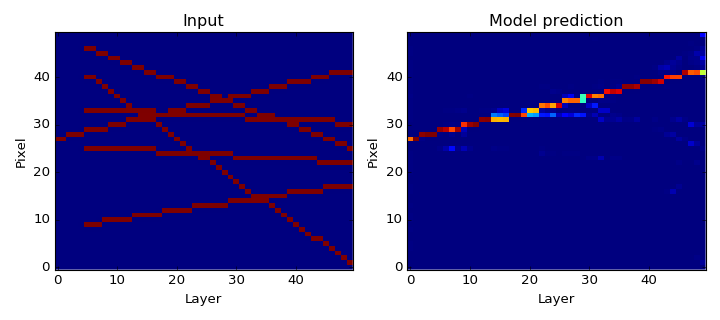

<IPython.core.display.Javascript object>


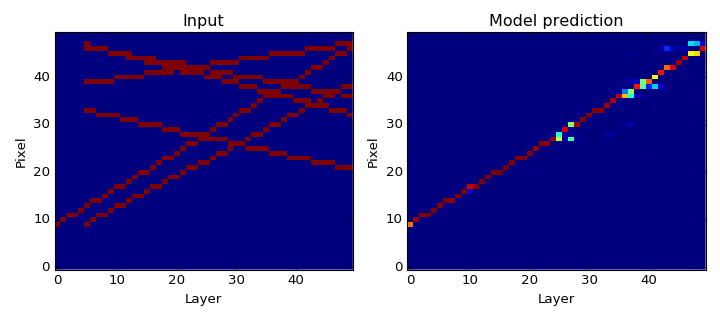

In [22]:
display_idx = 1234
draw_2d_input_and_pred(events5[display_idx], train5_pred[display_idx])

display_idx = 5432
draw_2d_input_and_pred(events5[display_idx], train5_pred[display_idx])

display_idx = 666
draw_2d_input_and_pred(events5[display_idx], train5_pred[display_idx])